In [1]:
import pandas as pd
import spacy
df = pd.read_csv("mbti_cf.csv")
lm = spacy.load('en')
for x_ in range(len(df[["posts"]])):
    lmtarget = lm(df.iloc[x_,1])
    lmstring = ''
    for word in lmtarget:
        lmstring = lmstring + word.lemma_ + ' '
    df.iloc[x_,1] = lmstring.lower()

In [2]:
df.head()

,cf,posts
0,Si,xx be a perceiving function that rely on senso...
1,Si,"mature xxxx be know for be dutiful , reliable ..."
2,Si,immature xxxx display the negative aspect of x...
3,Si,do -pron- feel most at ease when sensory detai...
4,Si,be -pron- very important to -pron- to proceed ...


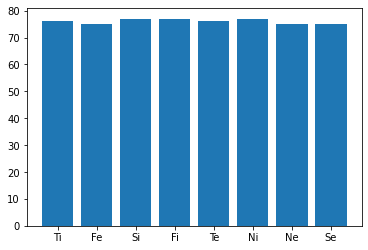

In [3]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(8)
cfs = set(df['cf'])
values = [int(len(df[df['cf'] == cf_])) for cf_ in cfs]
plt.bar(x,values)
plt.xticks(x,list(cfs))
plt.show()

In [4]:
len(df[df['cf'] == 'Ne'])

75

In [5]:
from sklearn.model_selection import train_test_split
import spacy
def load_data(train_data,limit=0, split=0.25):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    #random.shuffle(train_data)
    train_data = train_data[-limit:]
    Y,X = train_data["cf"], train_data["posts"]
    y = []
    for y_ in Y:
        if y_[0] == 'S' and y_[1] == 'e': Se = True
        else: Se = False
        if y_[0] == 'S' and y_[1] == 'i': Si = True
        else: Si = False
        if y_[0] == 'N' and y_[1] == 'e': Ne = True
        else: Ne = False
        if y_[0] == 'N' and y_[1] == 'i': Ni = True
        else: Ni = False
        if y_[0] == 'T' and y_[1] == 'e': Te = True
        else: Te = False
        if y_[0] == 'T' and y_[1] == 'i': Ti = True
        else: Ti = False
        if y_[0] == 'F' and y_[1] == 'e': Fe = True
        else: Fe = False
        if y_[0] == 'F' and y_[1] == 'i': Fi = True
        else: Fi = False
            
        y.append({'Se':Se,"Si":Si,"Ne":Ne,"Ni":Ni,"Te":Te,"Ti":Ti,"Fe":Fe,"Fi":Fi})
            
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    return (X_train, y_train), (X_test, y_test)

In [6]:
load_data(df)

((0      xx be a perceiving function that rely on senso...
  601    hmm , give -pron- a second … okay , -pron- kno...
  163    -pron- be confident that -pron- will figure -p...
  349    unhealthy xx expression : the problem in -pron...
  336    immature xx expression : -pron- be insecure an...
                               ...                        
  71     defines social relationship in term of potenti...
  106    have -pron- ever get feedback about be ( and/o...
  270    powerful xx be always keep tab on what be go o...
  435    speculate about underlie essence ; visualize i...
  102    do -pron- feeling strongly inform -pron- appro...
  Name: posts, Length: 456, dtype: object,
  [{'Se': False,
    'Si': True,
    'Ne': False,
    'Ni': False,
    'Te': False,
    'Ti': False,
    'Fe': False,
    'Fi': False},
   {'Se': False,
    'Si': False,
    'Ne': False,
    'Ni': False,
    'Te': False,
    'Ti': True,
    'Fe': False,
    'Fi': False},
   {'Se': False,
    'Si': False,
  

In [7]:
from __future__ import unicode_literals, print_function
import random
from pathlib import Path
import thinc.extra.datasets

import spacy
from spacy.util import minibatch, compounding

from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.read_csv("mbti_cf.csv")
lm = spacy.load('en')
for x_ in range(len(df[["posts"]])):
    lmtarget = lm(df.iloc[x_,1])
    lmstring = ''
    for word in lmtarget:
        lmstring = lmstring + word.lemma_ + ' '
    df.iloc[x_,1] = lmstring.lower()

def main(model=None, output_dir=None, n_iter=19, n_texts=1000):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat')
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add label to text classifier
    textcat.add_label('Se')
    textcat.add_label('Si')
    textcat.add_label('Ne')
    textcat.add_label('Ni')
    textcat.add_label('Te')
    textcat.add_label('Ti')
    textcat.add_label('Fe')
    textcat.add_label('Fi')

    # load the IMBD dataset
    print("Loading MBTI data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(df,limit=n_texts)
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('ITER','LOSS', 'P', 'R', 'F'))
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                           losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print('{0:.1f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t{4:.4f}'  # print a simple table
                  .format(i+1, losses['textcat'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    # test the trained model
    test_text = "I observe all the possibilities and am great at innovating and coming up with ideas."
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)

def load_data(train_data,limit=0, split=0.25):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    #random.shuffle(train_data)
    train_data = train_data[-limit:]
    Y,X = train_data["cf"], train_data["posts"]
    y = []
    for y_ in Y:
        if y_[0] == 'S' and y_[1] == 'e': Se = True
        else: Se = False
        if y_[0] == 'S' and y_[1] == 'i': Si = True
        else: Si = False
        if y_[0] == 'N' and y_[1] == 'e': Ne = True
        else: Ne = False
        if y_[0] == 'N' and y_[1] == 'i': Ni = True
        else: Ni = False
        if y_[0] == 'T' and y_[1] == 'e': Te = True
        else: Te = False
        if y_[0] == 'T' and y_[1] == 'i': Ti = True
        else: Ti = False
        if y_[0] == 'F' and y_[1] == 'e': Fe = True
        else: Fe = False
        if y_[0] == 'F' and y_[1] == 'i': Fi = True
        else: Fi = False
            
        y.append({'Se':Se,"Si":Si,"Ne":Ne,"Ni":Ni,"Te":Te,"Ti":Ti,"Fe":Fe,"Fi":Fi})
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    return (X_train, y_train), (X_test, y_test)

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label in ['Se','Si','Ne','Ni','Te','Ti','Fe','Fi']:
                if score == max([doc.cats['Se'],doc.cats['Si'],doc.cats['Ne'],doc.cats['Ni'],doc.cats['Te'],doc.cats['Ti'],doc.cats['Fe'],doc.cats['Fi']]) and gold[label] >= 0.5:
                    tp += 1.
                elif score == max([doc.cats['Se'],doc.cats['Si'],doc.cats['Ne'],doc.cats['Ni'],doc.cats['Te'],doc.cats['Ti'],doc.cats['Fe'],doc.cats['Fi']]) and gold[label] < 0.5:
                    fp += 1.
                elif score != max([doc.cats['Se'],doc.cats['Si'],doc.cats['Ne'],doc.cats['Ni'],doc.cats['Te'],doc.cats['Ti'],doc.cats['Fe'],doc.cats['Fi']]) and gold[label] < 0.5:
                    tn += 1.
                elif score != max([doc.cats['Se'],doc.cats['Si'],doc.cats['Ne'],doc.cats['Ni'],doc.cats['Te'],doc.cats['Ti'],doc.cats['Fe'],doc.cats['Fi']]) and gold[label] >= 0.5:
                    fn += 1.
            elif label not in gold:
                continue                  
                
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

main(output_dir="./mbti cf model")

Created blank 'en' model
Loading MBTI data...
Using 1000 examples (456 training, 152 evaluation)
Training the model...
ITER 	LOSS 	  P  	  R  	  F  
1.0	7.869	0.112	0.112	0.1118
2.0	6.872	0.145	0.145	0.1447
3.0	6.725	0.237	0.237	0.2368
4.0	6.355	0.283	0.283	0.2829
5.0	5.959	0.303	0.303	0.3026
6.0	5.345	0.408	0.408	0.4079
7.0	4.859	0.441	0.441	0.4408
8.0	4.009	0.461	0.461	0.4605
9.0	2.902	0.520	0.520	0.5197
10.0	2.367	0.546	0.546	0.5461
11.0	1.858	0.533	0.533	0.5329
12.0	1.357	0.546	0.546	0.5461
13.0	1.075	0.533	0.533	0.5329
14.0	0.727	0.520	0.520	0.5197
15.0	0.579	0.513	0.513	0.5132
16.0	0.513	0.579	0.579	0.5789
17.0	0.404	0.572	0.572	0.5724
18.0	0.352	0.546	0.546	0.5461
19.0	0.317	0.559	0.559	0.5592
I observe all the possibilities and am great at innovating and coming up with ideas. {'Se': 0.0018756382633000612, 'Si': 0.675885796546936, 'Ne': 0.00012522390170488507, 'Ni': 5.5730906751705334e-05, 'Te': 0.5813125967979431, 'Ti': 0.0005914797075092793, 'Fe': 0.0005956439999863505, 'Fi': 

#### 